In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from cnn_lstm_ocr import CNNLSTM_OCR
from tqdm.notebook import tqdm

# Define the CNNLSTM_OCR model and other hyperparameters
params = {
    "input_dim": 1,  # MNIST images are grayscale, so input_dim is 1
    "hidden_dim": 64,
    "output_dim": 10,  # 10 classes for digits 0-9
    "input_planes": 1,  # Input image has one channel (grayscale)
    "planes": 32,
    "max_width": 28,  # MNIST images have width and height of 28
    "batch_size": 1,
}
model = CNNLSTM_OCR(params)

# Define data transformations and prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

# Define data loaders
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define loss function and optimizer
criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [53]:
!export TORCH_USE_NNPACK=0

In [101]:
# Training loop
num_epochs = 3
device = torch.device("cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_data, batch_labels in tqdm(train_loader):
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        
        outputs = outputs.transpose(0, 1)

        # Reshape batch_labels to match the shape of outputs
        batch_labels = batch_labels.view(-1)  # Ensure the shape is compatible with CTC loss

        input_lengths = torch.full((batch_data.size(0),), outputs.size(0), dtype=torch.int64)
        target_lengths = torch.full((batch_labels.size(0),), batch_labels.size(0), dtype=torch.int64)
        
        # Print debug information
        print("Outputs shape:", outputs.shape)
        print("Batch labels shape:", batch_labels.shape)
        print("Input lengths:", input_lengths)
        print("Target lengths:", target_lengths)

        loss = criterion(outputs, batch_labels, input_lengths, target_lengths)
        if loss<0:
            print(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        break
    break

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {total_loss / len(train_loader)}")


  0%|          | 0/60000 [00:00<?, ?it/s]

Outputs shape: torch.Size([49, 1, 10])
Batch labels shape: torch.Size([1])
Input lengths: tensor([49])
Target lengths: tensor([1])


In [ ]:
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        outputs = model(batch_data)
        _, predicted = torch.max(outputs, 2)  # Get the predicted class
        print(predicted)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

In [96]:
import torch
from torch.utils.data import DataLoader

# Define a function for model evaluation
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation during evaluation
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Forward pass
            outputs = model(batch_data)
            
            # Get the predicted class by selecting the one with the highest probability
            predicted = outputs.argmax(2)  # Shape: (batch_size, sequence_length)
            
            # Compare the predicted labels to the true labels
            correct += (predicted == batch_labels).all(dim=1).sum().item()
            total += batch_data.size(0)

    accuracy = (correct / total) * 100.0
    return accuracy

# Assuming you have already trained and have the model and test_loader
# Define the device (CPU or GPU) to use for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate the model
accuracy = evaluate_model(model, test_loader, device)

print(f"Accuracy on the test dataset: {accuracy:.2f}%")


Accuracy on the test dataset: 0.27%


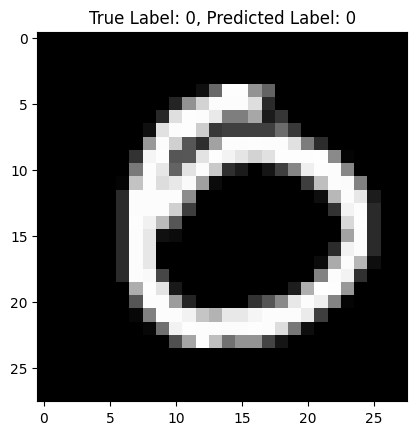

In [93]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# Assuming you have already defined your model and test_loader as before

# Set the model to evaluation mode
model.eval()

# Choose a random image from the test dataset
random_index = random.randint(0, len(test_loader.dataset) - 1)
image, label = test_loader.dataset[random_index]

# Preprocess the image (apply the same transformations used during training)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Ensure the image is in the format [C, H, W]
if image.dim() == 2:
    # If it's a grayscale image, add a channel dimension
    image = image.unsqueeze(0)
elif image.dim() == 3 and image.size(0) == 1:
    # If it's a grayscale image with an extra singleton dimension, squeeze it
    image = image.squeeze(0)

# Apply the transformation
input_image = image.unsqueeze(0).unsqueeze(0) # Add batch dimension

# Perform the prediction
with torch.no_grad():
    output = model(input_image)

# Get the predicted class label
predicted_label = torch.argmax(output, dim=2)

# Display the original image
plt.imshow(image.squeeze().numpy(), cmap='gray')  # Squeeze the image back to [H, W]
plt.title(f"True Label: {label}, Predicted Label: {predicted_label[0][0].item()}")
plt.show()


In [77]:
torch.save(model, "mnist_model.pth")

In [62]:
batch_labels

tensor([8])

In [63]:
batch_data.size()

torch.Size([1, 1, 28, 28])

In [64]:
input_lengths

tensor([1], dtype=torch.int32)

In [65]:
batch_size

1

In [67]:
outputs.transpose(0, 1).shape

torch.Size([49, 1, 10])